Neural Machine Translation is a way to convert one language to another language. Initially we were focused on the tranfering the Hindi to English but after that we switched to the French to English.
The dataset we sregoing to use is the french and english dataset which has French sentence with the English output or prediction sentences.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
#First we are going to add the libraries which will be required for this project
from __future__ import print_function, division
from builtins import range, input
import pickle
import os, sys
import string
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras import optimizers
from sklearn.model_selection import train_test_split
 
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [50]:
# Model configuration
BATCH_SIZE = 512
EPOCHS = 300
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 
EMBEDDING_DIM = 200


In [17]:
#Load train and test datasets
with open('/content/drive/MyDrive/Neural Machine Traslation/Part 2/French_test.pkl', 'rb') as handle:
    fr_test = pickle.load(handle)
with open('/content/drive/MyDrive/Neural Machine Traslation/Part 2/English_test.pkl', 'rb') as handle:
    en_test = pickle.load(handle)
with open('/content/drive/MyDrive/Neural Machine Traslation/Part 2/French_train.pkl', 'rb') as handle:
    fr_train = pickle.load(handle)[1:14000]
with open('/content/drive/MyDrive/Neural Machine Traslation/Part 2/English_train.pkl', 'rb') as handle:
    en_train = pickle.load(handle)[1:14000]

In [18]:

print(len(en_train))

13999


In [19]:
NUM_SAMPLES=len(fr_test)+len(fr_train)
print(NUM_SAMPLES)

27999


In [20]:
input_texts = [] 
target_texts = [] 
target_texts_inputs = []

fr_train=[line.lower() for line in fr_train]
en_train=[line.lower() for line in en_train]
NUM_SAMPLES=len(fr_train)
print("Sample train size:",NUM_SAMPLES)

Sample train size: 13999


In [21]:
print(len(input_texts))

0


In [22]:
#Pre processing of the Datasets 
'''
1. Add start and end tokens to the sentences.
2.Tokenize the word of the sentences.
3. Add padding to the sentences to make the all the sentences of the same length.
'''

#1. Add the start and end tokens to the start and end of the tokens.
for lines in en_train:
    target_texts_inputs.append('<sos>'+" "+ lines)
    
for lines in en_train:
    target_texts.append(lines+ " " +'<eos>')
    
for lines in fr_train:
    input_texts.append(lines)

**Here we have preprocessed the traing data**

In [23]:
#2. Tokenize the french and english sentences.
tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

#word to index mapping for the french language
word2idx_inputs = tokenizer_inputs.word_index

# Max length of French sentence
max_len_input = max(len(s) for s in input_sequences)
#print(max_len_input)
#tokenize English sentences
tokenizer_outputs = Tokenizer(filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# Word to index mapping for English
word2idx_outputs = tokenizer_outputs.word_index

# store number of output words for later
num_words_output = len(word2idx_outputs) + 1

# Max length of English sentence
max_len_target = max(len(s) for s in target_sequences)

# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

print('Data Preprocessed')
print("Max train English sentence length:", max_len_target)
print("Max train French sentence length:", max_len_input)
print("Unique French Vocabulary count:",len(word2idx_inputs))
print("Unique English Vocabulary count:",len(word2idx_outputs))

Data Preprocessed
Max train English sentence length: 8
Max train French sentence length: 9
Unique French Vocabulary count: 7157
Unique English Vocabulary count: 4080


**##Now we are going to pre process the test dataset##**

In [24]:
##Test Preparation
input_texts_test = [] # French sentences
target_texts_test = [] # English sentences
target_texts_inputs_test = []# english sentences offset by 1 for teacher forcing

#Converting to lowercase
fr_test=[line.lower() for line in fr_test]
en_test=[line.lower() for line in en_test]

#Adding <sos> and <eos> tokens

for lines in en_test:
    target_texts_inputs_test.append('<sos>'+" "+ lines)
    
for lines in en_test:
    target_texts_test.append(lines+ " " +'<eos>')
    
for lines in fr_test:
    input_texts_test.append(lines)
    
# tokenize French sentences

input_sequences_test = tokenizer_inputs.texts_to_sequences(input_texts_test)


target_sequences_test = tokenizer_outputs.texts_to_sequences(target_texts_test)
target_sequences_inputs_test = tokenizer_outputs.texts_to_sequences(target_texts_inputs_test)

# pad the sequences
encoder_inputs_test = pad_sequences(input_sequences_test, maxlen=max_len_input)
decoder_inputs_test = pad_sequences(target_sequences_inputs_test, maxlen=max_len_target, padding='post')
decoder_targets_test = pad_sequences(target_sequences_test, maxlen=max_len_target, padding='post')

print("Max test English sentence length:", decoder_inputs_test.shape[1])
print("Max test French sentence length:", encoder_inputs_test.shape[1])

Max test English sentence length: 8
Max test French sentence length: 9


In [25]:
#Load pretrained word vectors from Glove
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/content/drive/MyDrive/Neural Machine Traslation/Part 2/glove.6B.200d.txt'), encoding="utf8") as f:
# is just a space-separated text file in the format:
# word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [26]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words=len(word2idx_inputs) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < num_words:
        embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


# # Now we are creating model for the machine translartion using LSTM

In [27]:
#First define softmax activation function
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [28]:
#Define embedding layers
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [29]:
#One hot encoding

decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [30]:
#Define Encoding layer
#encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True, dropout=0.2
))
encoder_outputs = encoder(x)

In [31]:
#Define Decoding layer
#Decoder
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [32]:
#Attention layer
#Attention
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)

attn_dot = Dot(axes=1) 

In [33]:
def one_step_attention(h, st_1):

    st_1 = attn_repeat_layer(st_1)

    x = attn_concat_layer([h, st_1])

    # Neural net first layer
    x = attn_dense1(x)

    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)

    context = attn_dot([alphas, h])

    return context

In [34]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [35]:
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)

    # combine 
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)

In [36]:
def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size tensor
    x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
    x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
    return x

# make it a layerx``
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)


In [37]:
# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)


In [38]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 200)       1431600     input_1[0][0]                    
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 256)]        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 9, 512)       935936      embedding[0][0]                  
______________________________________________________________________________________________

In [39]:
learning_rate=0.001
# checkpoint
filepath="french_eng_finalmodel"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# compile the model

model.compile(optimizer=optimizers.Adam(learning_rate) ,loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
# train the model
z = np.zeros((encoder_inputs.shape[0], LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.1,
)

Epoch 1/300
25/25 [==============================] - 2s 91ms/step - loss: 2.1788 - accuracy: 0.6112 - val_loss: 3.0144 - val_accuracy: 0.5181
Epoch 2/300
25/25 [==============================] - 2s 84ms/step - loss: 2.1440 - accuracy: 0.6133 - val_loss: 2.9663 - val_accuracy: 0.5268
Epoch 3/300
25/25 [==============================] - 2s 85ms/step - loss: 2.0911 - accuracy: 0.6224 - val_loss: 2.9646 - val_accuracy: 0.5305
Epoch 4/300
25/25 [==============================] - 2s 85ms/step - loss: 2.0605 - accuracy: 0.6267 - val_loss: 2.9543 - val_accuracy: 0.5332
Epoch 5/300
25/25 [==============================] - 2s 84ms/step - loss: 2.0417 - accuracy: 0.6273 - val_loss: 2.9506 - val_accuracy: 0.5346
Epoch 6/300
25/25 [==============================] - 2s 85ms/step - loss: 2.0150 - accuracy: 0.6313 - val_loss: 2.9531 - val_accuracy: 0.5281
Epoch 7/300
25/25 [==============================] - 2s 85ms/step - loss: 1.9927 - accuracy: 0.6342 - val_loss: 2.9349 - val_accuracy: 0.5315
Epoch 

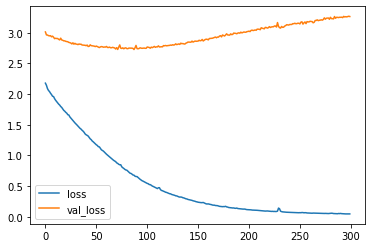

In [52]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

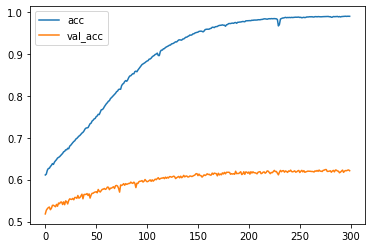

In [53]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')

plt.legend()
plt.show()

In [54]:
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])

# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [55]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


In [56]:
decoder_model.save("enfr_decoder_model.h5")
encoder_model.save("enfr_encoder_model.h5")

In [57]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [58]:
import pickle
pickle.dump( idx2word_eng, open( "idx2word_eng1.pkl", "wb" ) )
pickle.dump(idx2word_trans,open("idx2word_fr.pkl","wb"))
pickle.dump(tokenizer_inputs,open("tokenizer_inputs.pkl","wb"))

In [59]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']


    # [s, c] will be updated in each loop iteration
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))


    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
            

        # Get next word
        idx = np.argmax(o.flatten())

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [60]:
test_actual_sentence=[]
test_predicted_sentence=[]
for i in range(len(fr_test)-9000):
    # Do some test translations
    if i%10==0:
        print(i)
    input_seq = encoder_inputs_test[i:i+1]
    translation = decode_sequence(input_seq)

    test_actual_sentence.append(target_texts_test[i])
    test_predicted_sentence.append(translation)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [61]:
for i in np.random.randint(0,5000,5):
    print('-')
    print('Input sentence:', input_texts_test[i])
    print('Predicted translation:', test_predicted_sentence[i])
    print('Actual translation:', target_texts_test[i])

-
Input sentence: prenons un bus
Predicted translation: lets away the food
Actual translation: lets take a bus <eos>
-
Input sentence: cest un dictionnaire
Predicted translation: this is a dictionary
Actual translation: its a dictionary <eos>
-
Input sentence: il a nourri le cheval
Predicted translation: he went the job
Actual translation: he fed the horse <eos>
-
Input sentence: tout le monde le vit
Predicted translation: everybody saw it
Actual translation: everyone saw it <eos>
-
Input sentence: il va bien
Predicted translation: its well right
Actual translation: he is doing well <eos>


In [62]:
import nltk
pred=[]
for words in test_predicted_sentence:
    pred.append(words.split())

In [63]:
actual=[]
for words in test_actual_sentence:
    actual.append(words.split())

In [64]:
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()
BLEUscore = nltk.translate.bleu_score.corpus_bleu(actual,pred,smoothing_function=chencherry.method4)
print(BLEUscore)

0.15882657358816163


In [65]:
!pip install sacrebleu

     |████████████████████████████████| 61kB 5.9MB/s 


In [71]:
import sacrebleu
x=sacrebleu.raw_corpus_bleu(test_predicted_sentence,[test_actual_sentence])
print(x)

BLEU = 15.58 49.8/25.5/14.0/8.5 (BP = 0.791 ratio = 0.810 hyp_len = 21204 ref_len = 26164)


In [70]:
print(model)

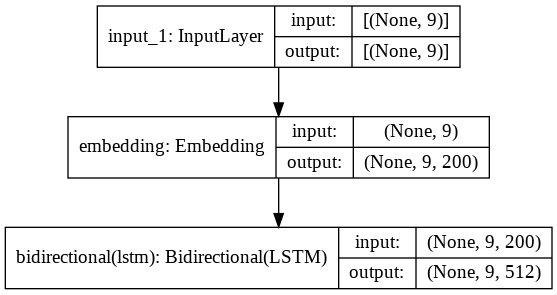

In [72]:
from keras.utils.vis_utils import plot_model
plot_model(encoder_model,to_file="decoder_model.png",show_shapes = True, show_layer_names = True )

Initialized empty Git repository in /content/.git/


In [3]:
!git add -A

In [4]:
!git commit -m “first commit”

error: pathspec 'commit”' did not match any file(s) known to git.
